<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%ED%96%89%EC%82%AC%20%EC%B0%B8%EC%97%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%EC%9D%84%20%ED%86%B5%ED%95%9C%20%EC%95%88%EC%A0%84%20%EA%B4%80%EB%A6%AC%20%EC%BB%A8%EC%84%A4%ED%8C%85%20%EC%84%9C%EB%B9%84%EC%8A%A4/1004%20%ED%96%89%EC%82%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%20%EB%AA%A8%EB%8D%B8%20(Ridge%26Lasso).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install --upgrade gensim

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from gensim.utils import simple_preprocess
import nltk
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# 데이터 가져오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DAB/Olympic_final_1.csv', encoding = 'cp949').iloc[:,1:]
df

,FCLTY_NM,EVENT_SDIV_NM,EVENT_NM,RENTLSPCE_BEGIN_DE,RENTLSPCE_END_DE,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,ISE_ELSE_FLAG_NM,USE_DAY_CO,WEEKDAY_BEGIN,...,HOLIDAY,YEAR_END,BEGIN_AVG_WEEKDAY,END_AVG_WEEKDAY,AVG_MONTH,년도,월,계절,텍스트,유사공연_가중평균
0,우리금융아트홀,문화예술행사,2012 공동주최 기획공연 뮤지컬 페임,2012-01-01,2012-01-29,19800,21363,내부,29,6,...,1,0,4671.767123,9046.742340,8519.324324,2012년,1월,겨울,우리금융아트홀 문화예술행사 2012 공동주최 기획공연 뮤지컬 페임 2012년 1월 ...,0.000000
1,핸드볼경기장,체육행사,2012코리아배드민턴슈퍼시리즈 프리미어대회,2012-01-03,2012-01-08,7000,14957,내부,6,1,...,0,0,5544.786885,9046.742340,8519.324324,2012년,1월,겨울,핸드볼경기장 체육행사 2012코리아배드민턴슈퍼시리즈 프리미어대회 2012년 1월 겨...,0.000000
2,올림픽홀,대중공연,데미안 라이스 내한공연,2012-01-11,2012-01-11,3000,3000,내부,1,2,...,0,0,4465.204819,5102.242857,8519.324324,2012년,1월,겨울,올림픽홀 대중공연 데미안 라이스 내한공연 2012년 1월 겨울 내부,14957.000000
3,올림픽홀,대중공연,아메바이펙트 콘서트,2012-01-27,2012-01-28,8500,5700,내부,2,4,...,0,0,9870.415686,3467.288401,8519.324324,2012년,1월,겨울,올림픽홀 대중공연 아메바이펙트 콘서트 2012년 1월 겨울 내부,8801.136446
4,KSPO DOME(체조경기장),문화예술행사,2011-12 브라운아이드소울 연말 콘서트,2012-01-28,2012-01-29,20000,16509,내부,2,5,...,0,0,6682.392273,9046.742340,8519.324324,2012년,1월,겨울,KSPO DOME(체조경기장) 문화예술행사 2011-12 브라운아이드소울 연말 콘서...,9132.724512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,뮤즈라이브,문화예술행사,BoA콘서트,2023-03-11,2023-03-12,6000,4504,내부,2,5,...,0,0,6682.392273,9046.742340,7098.186916,2023년,3월,봄,뮤즈라이브 문화예술행사 BoA콘서트 2023년 3월 봄 내부,1721.505796
1334,핸드볼경기장,문화예술행사,2023 윤하 앵콜 콘서트,2023-03-11,2023-03-12,8000,9493,내부,2,5,...,0,0,6682.392273,9046.742340,7098.186916,2023년,3월,봄,핸드볼경기장 문화예술행사 2023 윤하 앵콜 콘서트 2023년 3월 봄 내부,5695.938805
1335,평화의광장,공공행사,2023 서울마라톤 겸 동아마라톤,2023-03-19,2023-03-19,10000,10000,외부,1,6,...,0,0,4671.767123,9046.742340,7098.186916,2023년,3월,봄,평화의광장 공공행사 2023 서울마라톤 겸 동아마라톤 2023년 3월 봄 외부,6640.384870
1336,KSPO DOME(체조경기장),문화예술행사,해리 스타일스 내한공연 (HARRY STYLES LIVE IN SEOUL),2023-03-20,2023-03-20,14000,15100,내부,1,0,...,0,0,4026.739130,19989.096150,7098.186916,2023년,3월,봄,KSPO DOME(체조경기장) 문화예술행사 해리 스타일스 내한공연 (HARRY ST...,11203.942690


# 예측

#### 전처리

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FCLTY_NM              1338 non-null   object 
 1   EVENT_SDIV_NM         1338 non-null   object 
 2   EVENT_NM              1338 non-null   object 
 3   RENTLSPCE_BEGIN_DE    1338 non-null   object 
 4   RENTLSPCE_END_DE      1338 non-null   object 
 5   REQST_EVENT_NMPR_CO   1338 non-null   int64  
 6   EXCCLC_EVENT_NMPR_CO  1338 non-null   int64  
 7   ISE_ELSE_FLAG_NM      1338 non-null   object 
 8   USE_DAY_CO            1338 non-null   int64  
 9   WEEKDAY_BEGIN         1338 non-null   int64  
 10  WEEKDAY_END           1338 non-null   int64  
 11  WEEKEND               1338 non-null   int64  
 12  HOLIDAY               1338 non-null   int64  
 13  YEAR_END              1338 non-null   int64  
 14  BEGIN_AVG_WEEKDAY     1338 non-null   float64
 15  END_AVG_WEEKDAY      

In [ ]:
df["FCLTY_NM"].value_counts()

올림픽홀                413
핸드볼경기장              240
KSPO DOME(체조경기장)    213
뮤즈라이브               104
우리금융아트홀              87
K-아트홀                71
평화의광장                48
88잔디마당               42
88호수수변무대             30
올림픽컨벤션센터             27
피크닉광장                15
핸드볼보조경기장             13
한얼광장                 13
기타                    9
만남의광장                 3
몽촌해자수변무대B             3
몽촌해자수변무대A             3
올림픽수영장                3
벨로드롬                  1
Name: FCLTY_NM, dtype: int64

In [ ]:
df.loc[df["FCLTY_NM"] == "올림픽홀","FCLTY_NM"] = 1
df.loc[df["FCLTY_NM"] == "핸드볼경기장","FCLTY_NM"] = 2
df.loc[df["FCLTY_NM"] == "KSPO DOME(체조경기장)","FCLTY_NM"] = 3
df.loc[df["FCLTY_NM"] == "뮤즈라이브","FCLTY_NM"] = 4
df.loc[df["FCLTY_NM"] == "우리금융아트홀","FCLTY_NM"] = 5
df.loc[df["FCLTY_NM"] == "K-아트홀","FCLTY_NM"] = 6
df.loc[df["FCLTY_NM"] == "평화의광장","FCLTY_NM"] = 7
df.loc[df["FCLTY_NM"] == "88잔디마당","FCLTY_NM"] = 8
df.loc[df["FCLTY_NM"] == "88호수수변무대","FCLTY_NM"] = 9
df.loc[df["FCLTY_NM"] == "올림픽컨벤션센터","FCLTY_NM"] = 10
df.loc[df["FCLTY_NM"] == "피크닉광장","FCLTY_NM"] = 11
df.loc[df["FCLTY_NM"] == "핸드볼보조경기장","FCLTY_NM"] = 12
df.loc[df["FCLTY_NM"] == "한얼광장","FCLTY_NM"] = 13
df.loc[df["FCLTY_NM"] == "기타","FCLTY_NM"] = 14
df.loc[df["FCLTY_NM"] == "만남의광장","FCLTY_NM"] = 15
df.loc[df["FCLTY_NM"] == "몽촌해자수변무대B","FCLTY_NM"] = 16
df.loc[df["FCLTY_NM"] == "몽촌해자수변무대A","FCLTY_NM"] = 17
df.loc[df["FCLTY_NM"] == "올림픽수영장","FCLTY_NM"] = 18
df.loc[df["FCLTY_NM"] == "벨로드롬","FCLTY_NM"] = 19

In [ ]:
df.loc[df["EVENT_SDIV_NM"] == "문화예술행사","EVENT_SDIV_NM"] = 1
df.loc[df["EVENT_SDIV_NM"] == "대중공연","EVENT_SDIV_NM"] = 2
df.loc[df["EVENT_SDIV_NM"] == "체육행사","EVENT_SDIV_NM"] = 3
df.loc[df["EVENT_SDIV_NM"] == "공공행사","EVENT_SDIV_NM"] = 4
df.loc[df["EVENT_SDIV_NM"] == "순수예술공연","EVENT_SDIV_NM"] = 5

- 12월, 1월, 2월: 겨울 (1)
- 3월, 4월, 5월: 봄 (2)
- 6월, 7월, 8월: 여름 (3)
- 9월, 10월, 11월: 가을 (4)

In [ ]:
df["계절"] = 0

In [ ]:
# 년도에서 숫자만 출력
df['년도'] = df['년도'].str.extract(r'(\d+)')

In [ ]:
# 월에서 숫자만 출력
df['월'] = df['월'].str.extract(r'(\d+)')

In [ ]:
df = df.astype({'년도':'int','월':'int'})

In [ ]:
df.loc[(df["월"] == 12) | (df["월"] == 1) | (df["월"] == 2),"계절"] = 1
df.loc[(df["월"] == 3) | (df["월"] == 4) | (df["월"] == 5),"계절"] = 2
df.loc[(df["월"] == 6) | (df["월"] == 7) | (df["월"] == 8),"계절"] = 3
df.loc[(df["월"] == 9) | (df["월"] == 10) | (df["월"] == 11),"계절"] = 4

In [ ]:
df["계절"] = df["계절"].astype('category')
df["FCLTY_NM"] = df["FCLTY_NM"].astype('category')
df["EVENT_SDIV_NM"] = df["EVENT_SDIV_NM"].astype('category')
df["ISE_ELSE_FLAG_NM"] = df["ISE_ELSE_FLAG_NM"].astype('category')
df["WEEKDAY_BEGIN"] = df["WEEKDAY_BEGIN"].astype('category')
df["WEEKDAY_END"] = df["WEEKDAY_END"].astype('category')
df["WEEKEND"] = df["WEEKEND"].astype('category')
df["HOLIDAY"] = df["HOLIDAY"].astype('category')
df["YEAR_END"] = df["YEAR_END"].astype('category')
df.년도 = df.년도.astype('category')

In [ ]:
df.head()

,FCLTY_NM,EVENT_SDIV_NM,EVENT_NM,RENTLSPCE_BEGIN_DE,RENTLSPCE_END_DE,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,ISE_ELSE_FLAG_NM,USE_DAY_CO,WEEKDAY_BEGIN,...,HOLIDAY,YEAR_END,BEGIN_AVG_WEEKDAY,END_AVG_WEEKDAY,AVG_MONTH,년도,월,계절,텍스트,유사공연_가중평균
0,5,1,2012 공동주최 기획공연 뮤지컬 페임,2012-01-01,2012-01-29,19800,21363,내부,29,6,...,1,0,4671.767123,9046.742340,8519.324324,2012,1,1,우리금융아트홀 문화예술행사 2012 공동주최 기획공연 뮤지컬 페임 2012년 1월 ...,0.000000
1,2,3,2012코리아배드민턴슈퍼시리즈 프리미어대회,2012-01-03,2012-01-08,7000,14957,내부,6,1,...,0,0,5544.786885,9046.742340,8519.324324,2012,1,1,핸드볼경기장 체육행사 2012코리아배드민턴슈퍼시리즈 프리미어대회 2012년 1월 겨...,0.000000
2,1,2,데미안 라이스 내한공연,2012-01-11,2012-01-11,3000,3000,내부,1,2,...,0,0,4465.204819,5102.242857,8519.324324,2012,1,1,올림픽홀 대중공연 데미안 라이스 내한공연 2012년 1월 겨울 내부,14957.000000
3,1,2,아메바이펙트 콘서트,2012-01-27,2012-01-28,8500,5700,내부,2,4,...,0,0,9870.415686,3467.288401,8519.324324,2012,1,1,올림픽홀 대중공연 아메바이펙트 콘서트 2012년 1월 겨울 내부,8801.136446
4,3,1,2011-12 브라운아이드소울 연말 콘서트,2012-01-28,2012-01-29,20000,16509,내부,2,5,...,0,0,6682.392273,9046.742340,8519.324324,2012,1,1,KSPO DOME(체조경기장) 문화예술행사 2011-12 브라운아이드소울 연말 콘서...,9132.724512


#### Dataset 나누기

In [ ]:
# df_pred
X_1 = df.iloc[:,[0,1,5,8,21]].values
y_1 = df["EXCCLC_EVENT_NMPR_CO"].values

In [ ]:
# train & test set 분할
from sklearn.model_selection import train_test_split

# 8:2로 test train set 나누기
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size = 0.2, shuffle=True)

# train_set 한 번 더 나누기
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1,y_train1, test_size = 0.2, shuffle=True)

In [ ]:
# df_pred
X_2 = df.iloc[:,[0,5,8,12,15,17,18,19,21]].values
y_2 = df["EXCCLC_EVENT_NMPR_CO"].values

# 8:2로 test train set 나누기
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size = 0.2, shuffle=True)

# train_set 한 번 더 나누기
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2,y_train2, test_size = 0.2, shuffle=True)

#### Model 2 (회귀분석)
- 변수: 공연장소, 공연유형, 신청인원, 사용일수, vector3_col
- vector3_col: vector3 함수를 이용해 도출한 유사공연의 정산인원

In [ ]:
df_train1 = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)], axis=1)
df_train1.columns = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];
df_train1

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO
0,3.0,1.0,16000.0,1.0,4364.836691,8586
1,1.0,2.0,3000.0,2.0,7778.284845,1404
2,4.0,1.0,200.0,1.0,249.364563,50
3,6.0,2.0,400.0,2.0,172.002073,839
4,3.0,1.0,10000.0,1.0,2619.740586,10028
...,...,...,...,...,...,...
851,2.0,1.0,5000.0,2.0,2713.979555,5315
852,4.0,2.0,237.0,2.0,10514.282160,120
853,3.0,1.0,24000.0,3.0,31521.901850,22537
854,5.0,1.0,21500.0,40.0,15038.942010,16910


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model_reg1 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO ~ C(FCLTY_NM)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+유사공연_가중평균',data= df_train1).fit()
model_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.711
Model:                              OLS   Adj. R-squared:                  0.703
Method:                   Least Squares   F-statistic:                     81.76
Date:                  Mon, 09 Oct 2023   Prob (F-statistic):          3.12e-204
Time:                          11:33:36   Log-Likelihood:                -9258.6
No. Observations:                   856   AIC:                         1.857e+04
Df Residuals:                       830   BIC:                         1.869e+04
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1335.5912   1282.459      1.041      0.298   -1181.653    3852.835
C(FCLTY_NM)[T.2.0]        825.9522   1645.568      0.502      0.616   -2404.012    4055.917
C(FCLTY_NM)[T.3.0]       7308.0286   1717.160      4.256      0.000    3937.541    1.07e+04
C(FCLTY_NM)[T.4.0]      -1496.7481   1860.172     -0.805      0.421   -5147.942    2154.446
C(FCLTY_NM)[T.5.0]       -482.1997   2036.028     -0.237      0.813   -4478.568    3514.169
C(FCLTY_NM)[T.6.0]      -1769.0223   2184.046     -0.810      0.418   -6055.926    2517.881
C(FCLTY_NM)[T.7.0]      -1476.0160   3260.011     -0.453      0.651   -7874.852    4922.820
C(FCLTY_NM)[T.8.0]       4778.1208   2602.937      1.836      0.067    -330.993    9887.235
C(FCLTY_NM)[T.9.0]       -296.3698   3298.949     -0.090      0.928   -6771.633    6178.894
C(FCLTY_NM)[T.10.0]     -4955.2610   3517.212     -1.409      0.159   -1.19e+04    1948.416
C(FCLTY_NM)[T.11.0]      3637.6377   5136.640      0.708      0.479   -6444.695    1.37e+04
C(FCLTY_NM)[T.12.0]      1138.0992   4322.632      0.263      0.792   -7346.477    9622.675
C(FCLTY_NM)[T.13.0]      8825.4154   4090.428      2.158      0.031     796.616    1.69e+04
C(FCLTY_NM)[T.14.0]      2691.3890   4978.515      0.541      0.589   -7080.572    1.25e+04
C(FCLTY_NM)[T.15.0]      7403.5700   9159.872      0.808      0.419   -1.06e+04    2.54e+04
C(FCLTY_NM)[T.16.0]      1838.0669   9216.658      0.199      0.842   -1.63e+04    1.99e+04
C(FCLTY_NM)[T.17.0]      1.858e+05   1.02e+04     18.209      0.000    1.66e+05    2.06e+05
C(FCLTY_NM)[T.18.0]      1392.0592   8950.440      0.156      0.876   -1.62e+04     1.9e+04
C(FCLTY_NM)[T.19.0]       212.9681   1.25e+04      0.017      0.986   -2.42e+04    2.47e+04
C(EVENT_SDIV_NM)[T.2.0]  -138.2763   1357.778     -0.102      0.919   -2803.358    2526.805
C(EVENT_SDIV_NM)[T.3.0] -1824.7021   2011.266     -0.907      0.365   -5772.468    2123.063
C(EVENT_SDIV_NM)[T.4.0] -5101.8120   2510.113     -2.033      0.042      -1e+04    -174.897
C(EVENT_SDIV_NM)[T.5.0]   303.5383   4885.695      0.062      0.950   -9286.233    9893.310
REQST_EVENT_NMPR_CO         0.4246      0.017     24.851      0.000       0.391       0.458
USE_DAY_CO                167.6982     92.036      1.822      0.069     -12.953     348.349
유사공연_가중평균                   0.0821      0.077      1.070      0.285      -0.069       0.233
==============================================================================
Omnibus:                      872.010   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1138631.693
Skew:                          -3.582   Prob(JB):                         0.00
Kurtosis:                     181.530   Cond. No.                     9.19e+0

In [ ]:
x_cols = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","유사공연_가중평균"]

test_df

In [ ]:
df_test1 = pd.concat([pd.DataFrame(X_test1),pd.DataFrame(y_test1)], axis=1)
df_test1.columns = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];

In [ ]:
# 회귀분석을 통해 인원을 예측하는 함수

def makeprediction2(index,df):
  result = model_reg1.predict(df.loc[index,x_cols])
  return int(result)

In [ ]:
df_test1 = df_test1[df_test1["FCLTY_NM"] != 19.0]

In [ ]:
model_reg1.predict(df_test1[x_cols])

0       2420.983695
1      -2769.329877
2      16806.204222
3       3238.798409
4       5550.068836
           ...     
263     4601.760344
264     4886.486969
265     7903.311099
266    12168.796842
267    33158.653837
Length: 268, dtype: float64

In [ ]:
score2_df = pd.DataFrame([df_test1["EXCCLC_EVENT_NMPR_CO"],model_reg1.predict(df_test1[x_cols])],index=["test","predict"]).transpose()
score2_df

,test,predict
0,1150.0,2420.983695
1,150.0,-2769.329877
2,21621.0,16806.204222
3,2200.0,3238.798409
4,6500.0,5550.068836
...,...,...
263,1746.0,4601.760344
264,5927.0,4886.486969
265,14241.0,7903.311099
266,19565.0,12168.796842


In [ ]:
from matplotlib import pyplot as plt

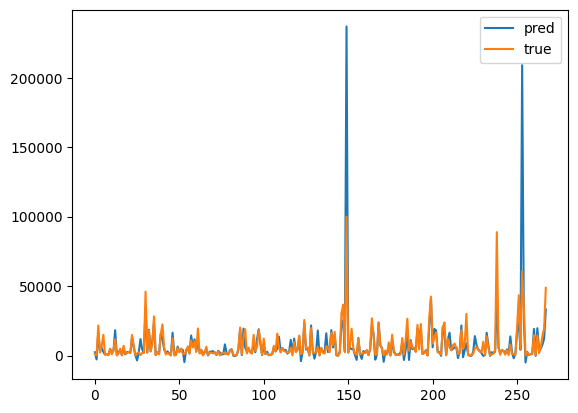

In [ ]:
plt.plot(np.array(model_reg1.predict(df_test1[x_cols])),label = "pred")
plt.plot(np.array(df_test1["EXCCLC_EVENT_NMPR_CO"]),label = "true")
plt.legend()
plt.show()

In [ ]:
# MSE
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test1["EXCCLC_EVENT_NMPR_CO"], model_reg1.predict(df_test1[x_cols]))

176926579.8922905

#### Model 2_1 (회귀분석)
- 변수: FCLTY_NM_cluster, 공연유형, 신청인원, 사용일수,vector3_col,
- 공연장소별 정산인원 평균을 내서 군집 4개로 만들고자 함.

공연장소별 정산인원 평균- 3개정도로 줄이기 > makeprediction2 적용해보기

- 공연장소  올림픽홀 (1), 핸드볼경기장 (2), KSPO DOME(체조경기장) (3), 뮤즈라이브 (4), 우리금융아트홀 (5),  K-아트홀 (6), 평화의광장 (7), 88잔디마당 (8), 88호수수변무대 (9), 올림픽컨벤션센터 (10), 피크닉광장 (11), 핸드볼보조경기장 (12), 한얼광장 (13), 기타 (14), 만남의광장 (15), 몽촌해자수변무대B (16), 몽촌해자수변무대A (17), 올림픽수영장 (18), 벨로드롬 (19)

In [ ]:
df_train1.groupby(['FCLTY_NM'], as_index=False).mean()["EXCCLC_EVENT_NMPR_CO"].sort_values(ascending = False)

# 10000명, 5000명, 1000명을 기준선으로 적용
# 16에 대한 평균값이 이상하게 크게 나와서 직접 계산하여 적용
# 1 (2,7,12)/ 2 (6,4,14,1)/ 3 (0,8,17,9,13,11,15,16,5)/ 4 (10,3,18)

16    300300.000000
2      18886.129496
7      13960.793103
12     13939.000000
14      9500.000000
4       7173.705882
1       5122.120253
6       4072.305556
0       3982.202381
8       3651.250000
17      2500.000000
13      2488.888889
11      2164.100000
9       1955.846154
5       1158.755556
3        487.267606
15       450.000000
10       352.750000
18        30.000000
Name: EXCCLC_EVENT_NMPR_CO, dtype: float64

In [ ]:
df_new = df_train1.copy()

# 1~4 군집 중 어디에 속하는 지
df_new["FCLTY_NM_cluster"] = 0
df_new.loc[(df_new["FCLTY_NM"]== 2) | (df_new["FCLTY_NM"]== 7) | (df_new["FCLTY_NM"]== 12), "FCLTY_NM_cluster"] = 1
df_new.loc[(df_new["FCLTY_NM"]== 6) | (df_new["FCLTY_NM"]== 4) | (df_new["FCLTY_NM"]== 14) | (df_new["FCLTY_NM"]== 1),"FCLTY_NM_cluster"] = 2
df_new.loc[(df_new["FCLTY_NM"]== 0) | (df_new["FCLTY_NM"]== 8) | (df_new["FCLTY_NM"]== 17) | (df_new["FCLTY_NM"]== 9) | (df_new["FCLTY_NM"]== 13) | (df_new["FCLTY_NM"]== 11) | (df_new["FCLTY_NM"]== 15)| (df_new["FCLTY_NM"]== 16) | (df_new["FCLTY_NM"]== 5),"FCLTY_NM_cluster"] = 3
df_new.loc[(df_new["FCLTY_NM"]== 10) | (df_new["FCLTY_NM"]== 3) | (df_new["FCLTY_NM"]== 18),"FCLTY_NM_cluster"] = 4
df_new

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO,FCLTY_NM_cluster
0,3.0,1.0,16000.0,1.0,4364.836691,8586,4
1,1.0,2.0,3000.0,2.0,7778.284845,1404,2
2,4.0,1.0,200.0,1.0,249.364563,50,2
3,6.0,2.0,400.0,2.0,172.002073,839,2
4,3.0,1.0,10000.0,1.0,2619.740586,10028,4
...,...,...,...,...,...,...,...
851,2.0,1.0,5000.0,2.0,2713.979555,5315,1
852,4.0,2.0,237.0,2.0,10514.282160,120,2
853,3.0,1.0,24000.0,3.0,31521.901850,22537,4
854,5.0,1.0,21500.0,40.0,15038.942010,16910,3


In [ ]:
model_reg1_new = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM_cluster)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+유사공연_가중평균',data= df_new).fit()
model_reg1_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.587
Model:                              OLS   Adj. R-squared:                  0.582
Method:                   Least Squares   F-statistic:                     109.2
Date:                  Mon, 09 Oct 2023   Prob (F-statistic):          7.36e-154
Time:                          11:33:38   Log-Likelihood:                -9411.4
No. Observations:                   856   AIC:                         1.885e+04
Df Residuals:                       844   BIC:                         1.890e+04
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 -957.0549   1.47e+04     -0.065      0.948   -2.98e+04    2.79e+04
C(FCLTY_NM_cluster)[T.1]   125.6478   1.46e+04      0.009      0.993   -2.86e+04    2.89e+04
C(FCLTY_NM_cluster)[T.2]  1983.5572   1.47e+04      0.135      0.893   -2.69e+04    3.09e+04
C(FCLTY_NM_cluster)[T.3]  5715.5728   1.47e+04      0.388      0.698   -2.32e+04    3.46e+04
C(FCLTY_NM_cluster)[T.4]  5280.3773   1.47e+04      0.358      0.720   -2.36e+04    3.42e+04
C(EVENT_SDIV_NM)[T.2.0]  -1122.0918   1345.731     -0.834      0.405   -3763.464    1519.280
C(EVENT_SDIV_NM)[T.3.0]    822.2992   2238.440      0.367      0.713   -3571.262    5215.861
C(EVENT_SDIV_NM)[T.4.0]  -1602.8032   1871.471     -0.856      0.392   -5276.086    2070.479
C(EVENT_SDIV_NM)[T.5.0]   -516.8734   5249.503     -0.098      0.922   -1.08e+04    9786.739
REQST_EVENT_NMPR_CO          0.5708      0.018     31.912      0.000       0.536       0.606
USE_DAY_CO                 -76.7192    100.410     -0.764      0.445    -273.802     120.363
유사공연_가중평균                    0.1466      0.085      1.720      0.086      -0.021       0.314
==============================================================================
Omnibus:                      648.466   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3205460.521
Skew:                           1.695   Prob(JB):                         0.00
Kurtosis:                     302.769   Cond. No.                     2.03e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 2_2 (회귀분석)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

In [ ]:
df_train2 = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)], axis=1)
df_train2.columns = ["FCLTY_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","HOLIDAY","END_AVG_WEEKDAY","년도","월","계절","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];
df_train2

,FCLTY_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,HOLIDAY,END_AVG_WEEKDAY,년도,월,계절,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO
0,1.0,12000.0,2.0,0.0,9046.742340,2022.0,4.0,2.0,4326.834577,4351
1,1.0,2500.0,1.0,0.0,5102.242857,2018.0,7.0,3.0,4740.228619,850
2,1.0,2000.0,1.0,0.0,5102.242857,2018.0,10.0,4.0,3217.990911,2380
3,7.0,500.0,1.0,0.0,5102.242857,2013.0,5.0,2.0,19096.687040,500
4,3.0,22500.0,2.0,0.0,9046.742340,2022.0,8.0,3.0,23700.675250,22388
...,...,...,...,...,...,...,...,...,...,...
851,3.0,16000.0,3.0,0.0,9046.742340,2016.0,9.0,4.0,14929.544910,28679
852,13.0,23.0,3.0,0.0,9046.742340,2022.0,9.0,4.0,12325.340450,5882
853,11.0,150.0,1.0,0.0,3467.288401,2018.0,10.0,4.0,2091.291640,150
854,1.0,7200.0,3.0,0.0,9046.742340,2016.0,12.0,1.0,5838.421333,4644


In [ ]:
model_reg2 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO ~ C(FCLTY_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+C(HOLIDAY)+END_AVG_WEEKDAY+C(년도)+C(월)+C(계절)+유사공연_가중평균',data= df_train2).fit()
model_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.647
Model:                              OLS   Adj. R-squared:                  0.628
Method:                   Least Squares   F-statistic:                     34.56
Date:                  Mon, 09 Oct 2023   Prob (F-statistic):          2.28e-153
Time:                          11:33:41   Log-Likelihood:                -8596.2
No. Observations:                   856   AIC:                         1.728e+04
Df Residuals:                       812   BIC:                         1.749e+04
Df Model:                            43                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -294.1787   1172.319     -0.251      0.802   -2595.313    2006.955
C(FCLTY_NM)[T.2.0]     56.8863    572.431      0.099      0.921   -1066.733    1180.506
C(FCLTY_NM)[T.3.0]   1.013e+04    727.878     13.914      0.000    8699.043    1.16e+04
C(FCLTY_NM)[T.4.0]  -2812.6136    841.063     -3.344      0.001   -4463.528   -1161.699
C(FCLTY_NM)[T.5.0]  -1759.5007    953.210     -1.846      0.065   -3630.547     111.546
C(FCLTY_NM)[T.6.0]  -3993.8776    956.105     -4.177      0.000   -5870.607   -2117.148
C(FCLTY_NM)[T.7.0]  -1507.1158   1074.661     -1.402      0.161   -3616.558     602.326
C(FCLTY_NM)[T.8.0]   8132.3897   1230.116      6.611      0.000    5717.808    1.05e+04
C(FCLTY_NM)[T.9.0]    226.5876   1437.503      0.158      0.875   -2595.073    3048.248
C(FCLTY_NM)[T.10.0] -3910.4650   1536.763     -2.545      0.011   -6926.961    -893.969
C(FCLTY_NM)[T.11.0] -2541.8440   2004.139     -1.268      0.205   -6475.749    1392.061
C(FCLTY_NM)[T.12.0] -3170.5895   2076.894     -1.527      0.127   -7247.303     906.124
C(FCLTY_NM)[T.13.0]  8248.3189   1876.072      4.397      0.000    4565.796    1.19e+04
C(FCLTY_NM)[T.14.0] -3834.6332   2954.222     -1.298      0.195   -9633.446    1964.180
C(FCLTY_NM)[T.15.0] -1896.9210   4105.001     -0.462      0.644   -9954.586    6160.744
C(FCLTY_NM)[T.16.0] -2066.2425   3442.558     -0.600      0.549   -8823.605    4691.120
C(FCLTY_NM)[T.18.0]   835.3358   5805.370      0.144      0.886   -1.06e+04    1.22e+04
C(HOLIDAY)[T.1.0]    -442.5164    775.226     -0.571      0.568   -1964.199    1079.166
C(년도)[T.2013.0]      1239.3820    969.269      1.279      0.201    -663.186    3141.950
C(년도)[T.2014.0]       936.2140    972.343      0.963      0.336    -972.388    2844.816
C(년도)[T.2015.0]       956.3571    889.895      1.075      0.283    -790.408    2703.122
C(년도)[T.2016.0]       374.3950    928.193      0.403      0.687   -1447.546    2196.336
C(년도)[T.2017.0]      3078.9844    983.255      3.131      0.002    1148.964    5009.005
C(년도)[T.2018.0]      1845.4216    873.316      2.113      0.035     131.199    3559.644
C(년도)[T.2019.0]      2798.5528    863.890      3.239      0.001    1102.831    4494.275
C(년도)[T.2020.0]      1786.4354   1782.357      1.002      0.317   -1712.136    5285.006
C(년도)[T.2021.0]      -497.5577   1377.446     -0.361      0.718   -3201.333    2206.217
C(년도)[T.2022.0]      1974.1806    982.329      2.010      0.045      45.976    3902.385
C(년도)[T.2023.0]        86.8957   1708.488      0.051      0.959   -3266.678    3440.469
C(월)[T.2.0]         -1048.9076   1161.102     -0.903      0.367   -3328.023    1230.208
C(월)[T.3.0]          1101.8479    620.893      1.775      0.076    -116.896    2320.592
C(월)[T.4.0]         -1404.9577    712.387     -1.972      0.049   -28

In [ ]:
x_cols = ["FCLTY_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","HOLIDAY","END_AVG_WEEKDAY","년도","월","계절","유사공연_가중평균"]

df_test2

In [ ]:
df_test2 = pd.concat([pd.DataFrame(X_test2),pd.DataFrame(y_test2)], axis=1)
df_test2.columns = ["FCLTY_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","HOLIDAY","END_AVG_WEEKDAY","년도","월","계절","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];
df_test2

,FCLTY_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,HOLIDAY,END_AVG_WEEKDAY,년도,월,계절,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO
0,12.0,1000.0,9.0,0.0,6651.437500,2019.0,4.0,2.0,829.246243,3300
1,1.0,4000.0,2.0,0.0,9046.742340,2012.0,8.0,3.0,4121.970614,5200
2,1.0,3000.0,3.0,0.0,3046.842105,2015.0,11.0,4.0,2217.585909,4267
3,10.0,760.0,1.0,0.0,3467.288401,2014.0,5.0,2.0,1332.773286,789
4,17.0,600.0,2.0,0.0,9046.742340,2012.0,10.0,4.0,12660.043010,600
...,...,...,...,...,...,...,...,...,...,...
263,1.0,6000.0,3.0,0.0,9046.742340,2022.0,3.0,2.0,5413.848226,3933
264,4.0,190.0,1.0,0.0,2788.224138,2018.0,12.0,1.0,1487.094018,128
265,8.0,20000.0,3.0,1.0,19989.096150,2022.0,10.0,4.0,6598.583704,17791
266,1.0,4500.0,2.0,0.0,9046.742340,2014.0,5.0,2.0,2898.484275,3920


In [ ]:
df_test2 = df_test2[df_test2["FCLTY_NM"] != 19.0]

In [ ]:
# 회귀분석을 통해 인원을 예측하는 함수

def makeprediction2_1(index,df):
  result = model_reg2.predict(df.loc[index,x_cols])
  return int(result)

In [ ]:
model_reg2.predict(df_test2[x_cols])

score2_2_df = pd.DataFrame([df_test2["EXCCLC_EVENT_NMPR_CO"],model_reg2.predict(df_test2[x_cols])],index=["test","predict"]).transpose()
score2_2_df


PatsyError: ignored

In [ ]:
plt.plot(np.array(model_reg2.predict(df_test2[x_cols])),label = "pred")
plt.plot(np.array(df_test2["EXCCLC_EVENT_NMPR_CO"]),label = "true")
plt.legend()
plt.show()

In [ ]:
mean_squared_error(df_test2["EXCCLC_EVENT_NMPR_CO"], model_reg2.predict(df_test2[x_cols]))

#### Model 3_1 (ANN)
- 변수:  공연장소, 공연유형, 신청인원, 사용일수, vector3_col

Buiding ANN

In [ ]:
import tensorflow as tf

In [ ]:
ann1 = tf.keras.models.Sequential()

In [ ]:
ann1.add(tf.keras.layers.Dense(units=4, activation='relu'))

In [ ]:
ann1.add(tf.keras.layers.Dense(units=6, activation='relu'))

In [ ]:
ann1.add(tf.keras.layers.Dense(units=1))

Training the ANN

In [ ]:
ann1.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])

In [ ]:
model_ann1 = ann1.fit(X_train1, y_train1, batch_size = 32, epochs = 25,validation_data=(X_val1, y_val1), shuffle=True)

Epoch 1/25
27/27 [==============================] - 2s 18ms/step - loss: 1223639808.0000 - mean_squared_logarithmic_error: 66.0845 - val_loss: 953746816.0000 - val_mean_squared_logarithmic_error: 64.2881
Epoch 2/25
27/27 [==============================] - 0s 11ms/step - loss: 1153470208.0000 - mean_squared_logarithmic_error: 66.0845 - val_loss: 859224320.0000 - val_mean_squared_logarithmic_error: 64.2881
Epoch 3/25
27/27 [==============================] - 0s 9ms/step - loss: 1077100288.0000 - mean_squared_logarithmic_error: 66.0845 - val_loss: 781135744.0000 - val_mean_squared_logarithmic_error: 64.2881
Epoch 4/25
27/27 [==============================] - 0s 10ms/step - loss: 1018438144.0000 - mean_squared_logarithmic_error: 66.0845 - val_loss: 691303424.0000 - val_mean_squared_logarithmic_error: 64.2881
Epoch 5/25
27/27 [==============================] - 0s 12ms/step - loss: 933685248.0000 - mean_squared_logarithmic_error: 66.0845 - val_loss: 595567040.0000 - val_mean_squared_logarithm

In [ ]:
# test set으로 예측 평가

y_pred1 = ann1.predict(X_test1)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred1.reshape(len(y_pred1),1), y_test1.reshape(len(y_test1),1)),1))

9/9 [==============================] - 0s 5ms/step
[[2.98e+03 3.68e+03]
 [2.36e+03 1.42e+03]
 [6.95e+03 1.19e+04]
 [5.47e+03 3.20e+03]
 [5.68e+02 4.57e+02]
 [5.46e+03 1.07e+03]
 [5.15e+03 3.76e+03]
 [3.19e+03 2.65e+03]
 [1.94e+02 1.80e+02]
 [2.98e+03 1.80e+03]
 [1.65e+03 1.03e+02]
 [5.44e+03 6.48e+03]
 [1.29e+04 9.22e+03]
 [2.11e+03 1.54e+03]
 [8.76e+02 1.50e+03]
 [3.30e+03 1.83e+03]
 [1.02e+04 1.20e+04]
 [4.50e+03 5.00e+03]
 [1.16e+04 2.07e+04]
 [8.69e+03 8.32e+03]
 [1.58e+03 1.74e+02]
 [1.42e+03 2.50e+02]
 [5.18e+03 1.48e+04]
 [1.48e+03 4.53e+02]
 [1.06e+04 1.81e+04]
 [1.31e+04 2.23e+03]
 [3.31e+03 5.35e+03]
 [2.68e+04 5.15e+04]
 [1.03e+04 7.55e+03]
 [1.14e+04 1.81e+04]
 [3.08e+03 3.28e+03]
 [2.80e+03 8.03e+03]
 [1.68e+04 5.79e+03]
 [8.29e+03 1.25e+04]
 [5.03e+02 3.00e+01]
 [1.28e+04 5.05e+03]
 [1.00e+04 1.30e+02]
 [1.21e+04 5.00e+02]
 [8.48e+03 5.00e+02]
 [1.98e+03 9.00e+02]
 [2.08e+03 2.22e+03]
 [2.04e+02 1.80e+02]
 [4.81e+03 9.71e+03]
 [4.84e+03 5.05e+03]
 [7.97e+03 8.26e+03]
 [2.

In [ ]:
import sklearn.metrics

evs_no=sklearn.metrics.explained_variance_score(y_test1,ann1.predict(X_test1))
mse_no=sklearn.metrics.mean_squared_error(y_test1,ann1.predict(X_test1))
msle_no=sklearn.metrics.mean_squared_log_error(y_test1,ann1.predict(X_test1))
r2_no=sklearn.metrics.r2_score(y_test1,ann1.predict(X_test1))

9/9 [==============================] - 0s 4ms/step


In [ ]:
print('Explained Variance Score:',evs_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('R2 Score                :',r2_no)

Explained Variance Score: 0.6298520335771924
Mean Square Error       : 26596948.939692102
Mean Squared Log Error  : 1.203673709045692
R2 Score                : 0.6259247249112762


dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


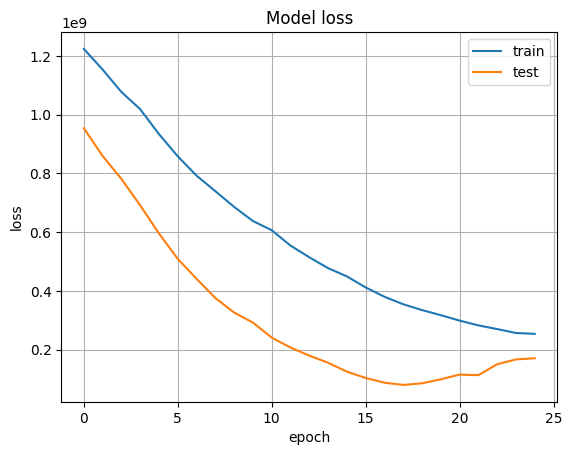

In [ ]:
# list all data in history
print(model_ann1.history.keys())
plt.plot(model_ann1.history['loss'])
plt.plot(model_ann1.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

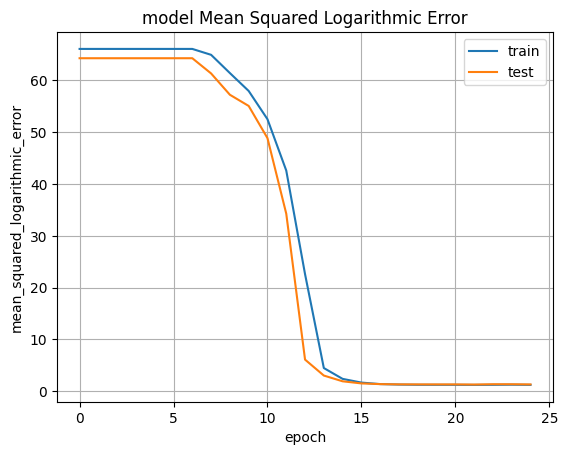

In [ ]:
# summarize history for loss
plt.plot(model_ann1.history['mean_squared_logarithmic_error'])
plt.plot(model_ann1.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
score3_df = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(y_pred1)], axis=1)
score3_df.columns = ["test","predict"]
score3_df

,test,predict
0,3678,2984.935059
1,1425,2361.966064
2,11924,6954.885254
3,3200,5470.072754
4,457,568.250183
...,...,...
263,8586,8743.244141
264,6232,17383.949219
265,4200,6242.640137
266,20483,23542.935547


#### Model 3_2 (ANN)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

In [ ]:
ann2 = tf.keras.models.Sequential()
ann2.add(tf.keras.layers.Dense(units=4, activation='relu'))
ann2.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann2.add(tf.keras.layers.Dense(units=1))

Training the ANN

In [ ]:
ann2.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])
model_ann2 = ann2.fit(X_train2, y_train2, batch_size = 32, epochs = 25,validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/25
27/27 [==============================] - 2s 24ms/step - loss: 475008064.0000 - mean_squared_logarithmic_error: 55.8129 - val_loss: 174521616.0000 - val_mean_squared_logarithmic_error: 55.4843
Epoch 2/25
27/27 [==============================] - 0s 6ms/step - loss: 456791200.0000 - mean_squared_logarithmic_error: 53.5074 - val_loss: 165889472.0000 - val_mean_squared_logarithmic_error: 53.8842
Epoch 3/25
27/27 [==============================] - 0s 6ms/step - loss: 440355648.0000 - mean_squared_logarithmic_error: 51.4425 - val_loss: 158036416.0000 - val_mean_squared_logarithmic_error: 51.9302
Epoch 4/25
27/27 [==============================] - 0s 5ms/step - loss: 425155552.0000 - mean_squared_logarithmic_error: 47.1977 - val_loss: 150856240.0000 - val_mean_squared_logarithmic_error: 48.3707
Epoch 5/25
27/27 [==============================] - 0s 6ms/step - loss: 408543360.0000 - mean_squared_logarithmic_error: 44.0007 - val_loss: 144687632.0000 - val_mean_squared_logarithmic_erro

test set으로 예측 평가

In [ ]:
y_pred2 = ann2.predict(X_test2)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred2.reshape(len(y_pred2),1), y_test2.reshape(len(y_test2),1)),1))

9/9 [==============================] - 0s 2ms/step
[[2.07e+03 2.84e+02]
 [5.12e+03 2.17e+03]
 [2.71e+03 1.43e+03]
 [2.94e+03 7.03e+02]
 [4.33e+04 3.48e+04]
 [4.19e+03 4.13e+03]
 [2.23e+03 1.00e+02]
 [1.98e+04 1.01e+04]
 [2.65e+03 1.80e+02]
 [2.49e+03 1.44e+02]
 [2.56e+03 2.83e+02]
 [4.43e+03 2.55e+03]
 [7.81e+03 2.98e+02]
 [8.20e+03 1.36e+04]
 [9.06e+03 4.60e+03]
 [5.88e+03 3.64e+02]
 [3.20e+03 1.00e+03]
 [4.14e+03 1.60e+04]
 [7.23e+03 5.22e+03]
 [9.57e+03 5.63e+03]
 [4.21e+03 1.90e+03]
 [3.02e+03 2.00e+03]
 [3.47e+03 9.92e+02]
 [9.01e+03 1.13e+04]
 [4.35e+03 2.22e+03]
 [8.26e+03 8.45e+03]
 [3.25e+03 1.00e+03]
 [5.97e+03 3.83e+03]
 [1.10e+04 2.87e+04]
 [2.54e+03 1.53e+03]
 [2.08e+04 2.00e+03]
 [4.18e+03 2.20e+03]
 [2.63e+03 1.00e+03]
 [3.15e+03 1.80e+03]
 [3.11e+03 1.89e+02]
 [9.48e+03 1.10e+04]
 [2.21e+03 3.40e+02]
 [1.55e+04 1.34e+04]
 [2.97e+03 1.96e+02]
 [5.81e+03 5.51e+03]
 [1.60e+04 3.02e+04]
 [6.07e+03 3.30e+02]
 [7.22e+03 1.19e+04]
 [2.84e+03 1.00e+04]
 [2.86e+03 1.61e+02]
 [4.

In [ ]:
evs_no=sklearn.metrics.explained_variance_score(y_test2,ann2.predict(X_test2))
mse_no=sklearn.metrics.mean_squared_error(y_test2,ann2.predict(X_test2))
msle_no=sklearn.metrics.mean_squared_log_error(y_test2,ann2.predict(X_test2))
r2_no=sklearn.metrics.r2_score(y_test2,ann2.predict(X_test2))

9/9 [==============================] - 0s 5ms/step


In [ ]:
print('Explained Variance Score:',evs_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('R2 Score                :',r2_no)

Explained Variance Score: -1.8152801058816888
Mean Square Error       : 252317213.42545536
Mean Squared Log Error  : 1.8061673783973697
R2 Score                : -1.8205279665522953


dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


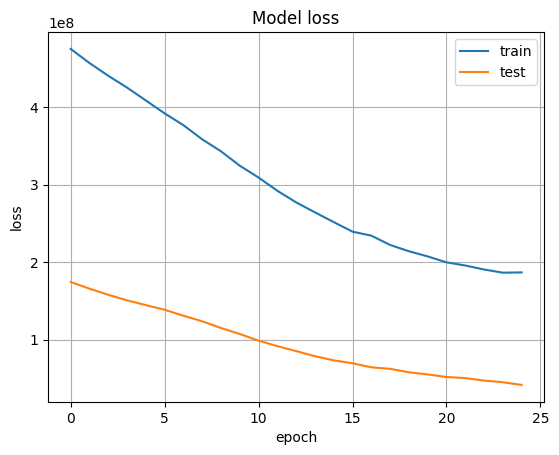

In [ ]:
# list all data in history
print(model_ann2.history.keys())
plt.plot(model_ann2.history['loss'])
plt.plot(model_ann2.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

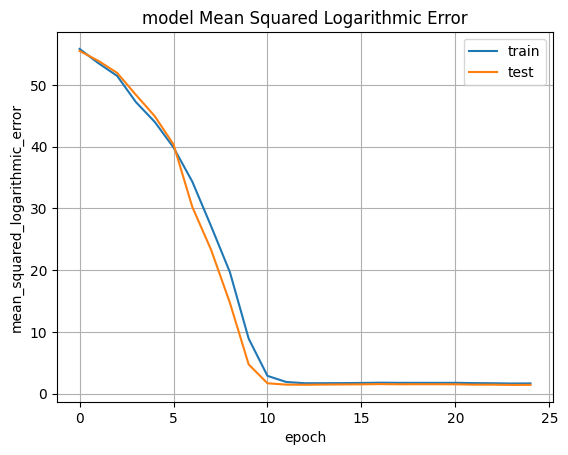

In [ ]:
# summarize history for loss
plt.plot(model_ann2.history['mean_squared_logarithmic_error'])
plt.plot(model_ann2.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
score3_df = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(y_pred2)], axis=1)
score3_df.columns = ["test","predict"]
score3_df

,test,predict
0,284,2065.076660
1,2170,5117.453125
2,1433,2707.845459
3,703,2936.733154
4,34809,43332.281250
...,...,...
263,19029,5844.231445
264,3300,4618.331055
265,1520,3636.537354
266,4778,6027.989746


#### Model 4_1 (Ridge, Lasso)
- 변수: 공연장소, 공연유형, 신청인원,사용일수, vector3_col

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_train1, y_train1)
  train_score.append(ridge.score(X_train1, y_train1))
  test_score.append(ridge.score(X_test1, y_test1))

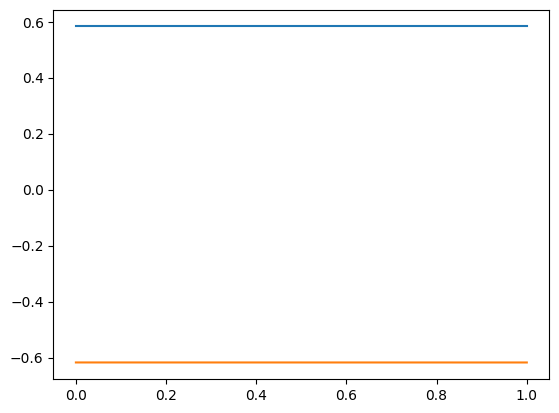

In [ ]:
plt.plot(alpha_list, train_score)
plt.plot(alpha_list, test_score)
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

0.0001

Ridge Regression

In [ ]:
model4_ridge = Ridge(0.0001)
model4_ridge.fit(X_train1, y_train1)
y_pred_ri = model4_ridge.predict(X_test1)

mean_squared_error(y_test1, y_pred_ri)

230555432.88443714

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(ridge.score(X_train1, y_train1)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge.score(X_test1, y_test1)))

훈련 세트의 정확도 : 0.58
테스트 세트의 정확도 : -0.62


In [ ]:
score4_ri = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(y_pred_ri)], axis=1)
score4_ri.columns = ["test","predict"]
score4_ri

,test,predict
0,1150,2121.591591
1,150,2840.701896
2,21621,12062.449909
3,2200,2343.811875
4,6500,5638.985589
...,...,...
263,1746,6909.710453
264,5927,4284.428040
265,14241,8687.011155
266,19565,5838.112101


Lasso Regression

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  lasso = Lasso(alpha = alpha, max_iter = 10000)
  lasso.fit(X_train1, y_train1)
  train_score.append(lasso.score(X_train1, y_train1))
  test_score.append(lasso.score(X_test1, y_test1))

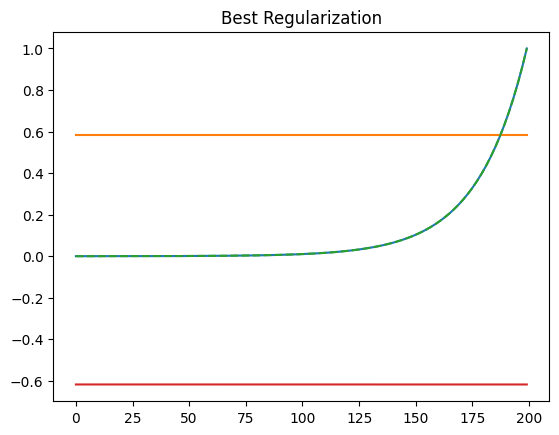

In [ ]:
plt.plot(alpha_list, '-',train_score)
plt.plot(alpha_list, '--',test_score)
plt.title("Best Regularization")
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

0.0001

In [ ]:
model4_lasso = Lasso(0.6)
model4_lasso.fit(X_train1, y_train1)
y_pred_la = model4_lasso.predict(X_test1)

mean_squared_error(y_test1, y_pred_la)

230559819.78555188

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(lasso.score(X_train1, y_train1)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso.score(X_test1, y_test1)))

훈련 세트의 정확도 : 0.58
테스트 세트의 정확도 : -0.62


In [ ]:
score4_la = pd.concat([pd.DataFrame(y_test1), pd.DataFrame(y_pred_la)], axis=1)
score4_la.columns = ["test","predict"]
score4_la

,test,predict
0,1150,2121.273597
1,150,2841.813781
2,21621,12061.856733
3,2200,2344.301065
4,6500,5638.732173
...,...,...
263,1746,6909.817509
264,5927,4284.950991
265,14241,8686.725851
266,19565,5837.531347


#### Model 4-2 (Ridge, Lasso)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_train2, y_train2)
  train_score.append(ridge.score(X_train2, y_train2))
  test_score.append(ridge.score(X_test2, y_test2))

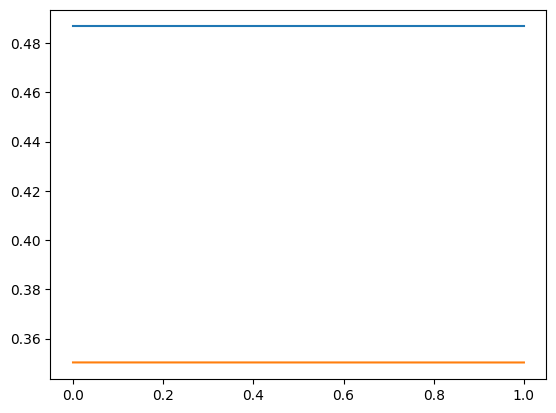

In [ ]:
plt.plot(alpha_list, train_score)
plt.plot(alpha_list, test_score)
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

0.0001

Ridge Regression

In [ ]:
model4_2_ridge = Ridge(1)
model4_2_ridge.fit(X_train2, y_train2)
y_pred_ri = model4_2_ridge.predict(X_test2)

mean_squared_error(y_test2, y_pred_ri)

906724065.3484772

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(ridge.score(X_train2, y_train2)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge.score(X_test2, y_test2)))

훈련 세트의 정확도 : 0.49
테스트 세트의 정확도 : 0.35


In [ ]:
score4_2_ri = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(y_pred_ri)], axis=1)
score4_2_ri.columns = ["test","predict"]
score4_2_ri

,test,predict
0,3300,3014.853835
1,5200,4741.335227
2,4267,2544.132208
3,789,-96.090471
4,600,5548.550139
...,...,...
263,3933,6776.256563
264,128,1959.433630
265,17791,12915.505340
266,3920,4492.441366


Lasso Regression

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  lasso = Lasso(alpha = alpha, max_iter = 10000)
  lasso.fit(X_train2, y_train2)
  train_score.append(lasso.score(X_train2, y_train2))
  test_score.append(lasso.score(X_test2, y_test2))

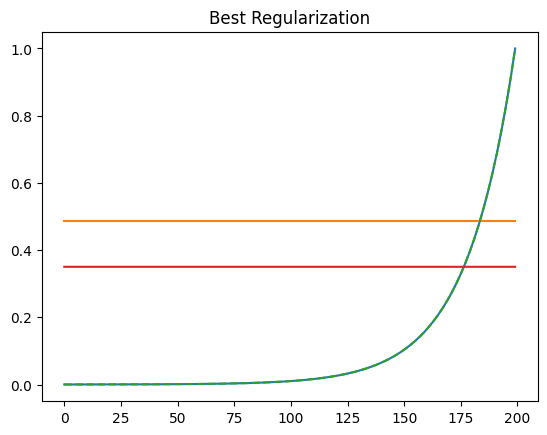

In [ ]:
plt.plot(alpha_list, '-',train_score)
plt.plot(alpha_list, '--',test_score)
plt.title("Best Regularization")
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

0.0001

In [ ]:
model4_2_lasso = Lasso(0.05)
model4_2_lasso.fit(X_train2, y_train2)
y_pred_la = model4_2_lasso.predict(X_test2)

mean_squared_error(y_test2, y_pred_la)

906698589.592597

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(lasso.score(X_train2, y_train2)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso.score(X_test2, y_test2)))

훈련 세트의 정확도 : 0.49
테스트 세트의 정확도 : 0.35


In [ ]:
score4_2_la = pd.concat([pd.DataFrame(y_test2), pd.DataFrame(y_pred_la)], axis=1)
score4_2_la.columns = ["test","predict"]
score4_2_la

,test,predict
0,3300,3013.245110
1,5200,4740.748188
2,4267,2543.489951
3,789,-96.321289
4,600,5547.762245
...,...,...
263,3933,6775.422551
264,128,1959.218831
265,17791,12921.890779
266,3920,4491.902267


#### 성능지표

 인터뷰 "예측인원이 실제 인원의 10% 오차 범위에 있다면 사용할 것 같다"에 기반하여 지표 생성하고자 함.

(1) 선형회귀모델
(2) ANN 모델
: 몇 퍼센트의 성공률을 보이는지

In [ ]:
# model1(평균)의 mse:
# model2(회귀분석)의 mse:  420365390.5968888
# model2_2(회귀분석)의 mse: 119739947.99359883
# model3(ANN)의 mse:21956005.58449393
# model4(Ridge)의 mse:
# model4(Lasso)의 mse:

오차범위계산 함수 (예측 인원이 실제 인원의 10% 오차 범위에 있는지 여부)

In [ ]:
def Error_fun(df,real, predict):
  df["pre_success"] = (df[predict] >= df[real]*0.9) & (df[predict] <= df[real]*1.1)
  return len(df.loc[df["pre_success"] == True])/len(df) # 예측 퍼센트 도출

In [ ]:
Error_fun(score2_df,"test","predict")

0.1647940074906367

In [ ]:
Error_fun(score2_2_df,"test","predict")

0.07462686567164178

In [ ]:
Error_fun(score3_df,"test","predict")

0.08582089552238806

In [ ]:
Error_fun(score4_la,"test","predict")

0.1417910447761194

In [ ]:
Error_fun(score4_ri,"test","predict")

0.1417910447761194

In [ ]:
Error_fun(score4_2_la,"test","predict")

0.09328358208955224

In [ ]:
Error_fun(score4_2_ri,"test","predict")

0.09328358208955224